## Contents
1. Import Libraries and Set Directory
2. Data Cleaning
    * Functions
    * Total Demand
    * Temperature
    * Forecast Demand
    * Energy Prices and Demand
    * BOM
    * Calculated Columns
    * Remove Redundant Columns
    * Merge Datasets
3. Exploratory Data Analysis
    * Total Demand Timeseries
    * Temperature Timeseries
    * Rain Timeseries
    * Timeseries Comparison
    * Timeseries Comparison with Kernal Smoothing

In [1]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import zipfile
import tempfile # for temporary file storage to avoid storing large datasets on github
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
base_dir = os.path.dirname(os.path.abspath("..\data"))
path = os.path.join(base_dir, r"data")
os.chdir(path)

In [3]:
# os.listdir()

## Data Cleaning

#### Functions

In [4]:
# read zips from repo, extract data into temp dir, create dataframes
def zip_to_df(file_name):
    # create temporary directory  
    with tempfile.TemporaryDirectory() as tmpdirname:
        # collect data from zip file 
        with zipfile.ZipFile(file_name+".zip") as zip_file:
            file_list = zip_file.namelist()
            for file in file_list:
               zip_file.extract(file, tmpdirname)
            file_path = tmpdirname+"\\"+file_name
            # create and return dataframe
            df = pd.read_csv(file_path)
            return df

#### Total Demand

In [5]:
file_name = "totaldemand_nsw.csv"
totalDemand = zip_to_df(file_name)
print("Rows:", len(totalDemand))
totalDemand.head()

Rows: 1323398


,DATETIME,REGIONID,TOTALDEMAND
0,2010-01-01 00:00:00,NSW1,7997.41
1,2010-01-01 00:05:00,NSW1,7946.51
2,2010-01-01 00:10:00,NSW1,7921.55
3,2010-01-01 00:15:00,NSW1,7837.84
4,2010-01-01 00:20:00,NSW1,7781.11


In [6]:
#update datatypes
totalDemand['DATETIME'] = pd.to_datetime(totalDemand['DATETIME'])
totalDemand.dtypes

DATETIME       datetime64[ns]
REGIONID               object
TOTALDEMAND           float64
dtype: object

#### Temperature

In [7]:
file_name = "temperature_nsw.csv"
temperature = zip_to_df(file_name)
print("Rows:", len(temperature))
temperature.head()

Rows: 247646


,DATETIME,LOCATION,TEMPERATURE
0,2010-01-01 00:00:00,94766.0,23.1
1,2010-01-01 00:01:00,94766.0,23.1
2,2010-01-01 00:30:00,94766.0,22.9
3,2010-01-01 00:50:00,94766.0,22.7
4,2010-01-01 01:00:00,94766.0,22.6


In [8]:
#update datatypes
temperature['DATETIME'] = pd.to_datetime(temperature['DATETIME'])
temperature.dtypes

DATETIME       datetime64[ns]
LOCATION              float64
TEMPERATURE           float64
dtype: object

#### Forecast Demand

In [9]:
file_name = "forecastdemand_nsw.csv"
forecastDemand = zip_to_df(file_name)
print("Rows:", len(forecastDemand))
forecastDemand.head()

Rows: 11619503


,DATETIME,REGIONID,FORECASTDEMAND,PREDISPATCHSEQNO,PERIODID,LASTCHANGED
0,2010-01-01 00:00:00,NSW1,7832.04,2009123018,71,2009-12-30 12:31:49
1,2010-01-01 00:00:00,NSW1,7832.04,2009123019,70,2009-12-30 13:01:43
2,2010-01-01 00:00:00,NSW1,7832.03,2009123020,69,2009-12-30 13:31:36
3,2010-01-01 00:00:00,NSW1,7832.03,2009123021,68,2009-12-30 14:01:44
4,2010-01-01 00:00:00,NSW1,7830.96,2009123022,67,2009-12-30 14:31:35


In [10]:
#update datatypes
forecastDemand['DATETIME'] = pd.to_datetime(forecastDemand['DATETIME'])
forecastDemand['LASTCHANGED'] = pd.to_datetime(forecastDemand['LASTCHANGED'])
forecastDemand.dtypes

DATETIME            datetime64[ns]
REGIONID                    object
FORECASTDEMAND             float64
PREDISPATCHSEQNO             int64
PERIODID                     int64
LASTCHANGED         datetime64[ns]
dtype: object

#### Energy Prices and Demand

In [11]:
#merge all files in folder
wd = path + r"\Price and Demand - 2010-22"
files = os.listdir(wd)
prices = pd.DataFrame([])
file_count = 0
for file in files:
    if file.endswith(".csv"):
        file_df = pd.read_csv(wd + "\\" + file)
        prices = prices.append(file_df, ignore_index=True)
        file_count += 1
print("Merged", file_count, "files")
#remove additional headers 
prices = prices[prices["REGION"]!="REGION"]
print("Rows:", len(prices))
prices.head()

Merged 153 files
Rows: 337488


,REGION,SETTLEMENTDATE,TOTALDEMAND,RRP,PERIODTYPE
0,NSW1,2010/01/01 00:30:00,7809.31,21.5,TRADE
1,NSW1,2010/01/01 01:00:00,7483.69,20.98,TRADE
2,NSW1,2010/01/01 01:30:00,7117.23,20.06,TRADE
3,NSW1,2010/01/01 02:00:00,6812.03,17.93,TRADE
4,NSW1,2010/01/01 02:30:00,6544.33,17.43,TRADE


In [12]:
#update datatypes
prices['SETTLEMENTDATE'] = pd.to_datetime(prices['SETTLEMENTDATE'])
prices['TOTALDEMAND'] = prices['TOTALDEMAND'].astype(float)
prices['RRP'] = prices['RRP'].astype(float)
prices.dtypes

REGION                    object
SETTLEMENTDATE    datetime64[ns]
TOTALDEMAND              float64
RRP                      float64
PERIODTYPE                object
dtype: object

#### BOM

In [13]:
# timeframe restriction
year_start = 2010

In [14]:
file_path = path + r"\Solar Exposure - Bankstown Airport\IDCJAC0016_066137_1800_Data.csv"
bomSolar = pd.read_csv(file_path)
bomSolar = bomSolar[bomSolar.Year >= year_start]
print("Rows:", len(bomSolar))
bomSolar.head()

Rows: 4816


,Product code,Bureau of Meteorology station number,Year,Month,Day,Daily global solar exposure (MJ/m*m)
7305,IDCJAC0016,66137,2010,1,1,14.6
7306,IDCJAC0016,66137,2010,1,2,18.4
7307,IDCJAC0016,66137,2010,1,3,7.3
7308,IDCJAC0016,66137,2010,1,4,14.4
7309,IDCJAC0016,66137,2010,1,5,28.1


In [15]:
bomSolar.dtypes

Product code                             object
Bureau of Meteorology station number      int64
Year                                      int64
Month                                     int64
Day                                       int64
Daily global solar exposure (MJ/m*m)    float64
dtype: object

In [16]:
file_path = path + r"\Temperature - Bankstown Airport\IDCJAC0010_066137_1800_Data.csv"
bomTemp = pd.read_csv(file_path)
bomTemp = bomTemp[bomTemp.Year >= year_start]
print("Rows:", len(bomTemp))
bomTemp.head()

Rows: 4816


,Product code,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Days of accumulation of maximum temperature,Quality
15341,IDCJAC0010,66137,2010,1,1,29.6,1.0,Y
15342,IDCJAC0010,66137,2010,1,2,29.5,1.0,Y
15343,IDCJAC0010,66137,2010,1,3,21.0,1.0,Y
15344,IDCJAC0010,66137,2010,1,4,24.0,1.0,Y
15345,IDCJAC0010,66137,2010,1,5,30.4,1.0,Y


In [17]:
bomTemp.dtypes

Product code                                    object
Bureau of Meteorology station number             int64
Year                                             int64
Month                                            int64
Day                                              int64
Maximum temperature (Degree C)                 float64
Days of accumulation of maximum temperature    float64
Quality                                         object
dtype: object

In [18]:
file_path = path + r"\Rainfall - Bankstown\IDCJAC0009_066137_1800_Data.csv"
bomRain = pd.read_csv(file_path)
bomRain = bomRain[bomRain.Year >= year_start]
print("Rows:", len(bomRain))
bomRain.head()

Rows: 4817


,Product code,Bureau of Meteorology station number,Year,Month,Day,Rainfall amount (millimetres),Period over which rainfall was measured (days),Quality
15341,IDCJAC0009,66137,2010,1,1,0.2,1.0,N
15342,IDCJAC0009,66137,2010,1,2,0.0,1.0,N
15343,IDCJAC0009,66137,2010,1,3,15.2,1.0,N
15344,IDCJAC0009,66137,2010,1,4,0.2,1.0,N
15345,IDCJAC0009,66137,2010,1,5,0.0,1.0,N


In [19]:
bomRain.dtypes

Product code                                       object
Bureau of Meteorology station number                int64
Year                                                int64
Month                                               int64
Day                                                 int64
Rainfall amount (millimetres)                     float64
Period over which rainfall was measured (days)    float64
Quality                                            object
dtype: object

#### Calculated Columns

In [20]:
def collect_date_time(df, col):
    df["DATE"] = df[col].dt.date
    df["YEAR"] = df[col].dt.year
    df["MONTH"] = df[col].dt.month
    df["DAY"] = df[col].dt.day
    df["TIME"] = df[col].dt.time
    df["HOURS"] = df[col].dt.hour
    df["MINUTES"] = df[col].dt.minute
    return df

In [21]:
forecastDemand = collect_date_time(forecastDemand, "DATETIME")
temperature = collect_date_time(temperature, "DATETIME")
prices = collect_date_time(prices, "SETTLEMENTDATE")
totalDemand = collect_date_time(totalDemand, "DATETIME")
# Example output
totalDemand.head()

,DATETIME,REGIONID,TOTALDEMAND,DATE,YEAR,MONTH,DAY,TIME,HOURS,MINUTES
0,2010-01-01 00:00:00,NSW1,7997.41,2010-01-01,2010,1,1,00:00:00,0,0
1,2010-01-01 00:05:00,NSW1,7946.51,2010-01-01,2010,1,1,00:05:00,0,5
2,2010-01-01 00:10:00,NSW1,7921.55,2010-01-01,2010,1,1,00:10:00,0,10
3,2010-01-01 00:15:00,NSW1,7837.84,2010-01-01,2010,1,1,00:15:00,0,15
4,2010-01-01 00:20:00,NSW1,7781.11,2010-01-01,2010,1,1,00:20:00,0,20


In [22]:
def categorise_hours(df, col="HOURS"):
    conditions = [
        (df[col] >= 0) & (df[col] < 3),
        (df[col] >= 3) & (df[col] < 6),
        (df[col] >= 6) & (df[col] < 9),
        (df[col] >= 9) & (df[col] < 12),
        (df[col] >= 12) & (df[col] < 15),
        (df[col] >= 15) & (df[col] < 18),
        (df[col] >= 18) & (df[col] < 21),
        (df[col] >= 21) & (df[col] < 0),
    ]
    choices = [1, 2, 3, 4, 5, 6, 7, 8]
    df["HOURGROUP"] = np.select(conditions, choices, default=0)
    return df

In [23]:
totalDemand = categorise_hours(totalDemand)
forecastDemand = categorise_hours(forecastDemand)
temperature = categorise_hours(temperature)
prices = categorise_hours(prices)
# Example output
prices.head()

,REGION,SETTLEMENTDATE,TOTALDEMAND,RRP,PERIODTYPE,DATE,YEAR,MONTH,DAY,TIME,HOURS,MINUTES,HOURGROUP
0,NSW1,2010-01-01 00:30:00,7809.31,21.50,TRADE,2010-01-01,2010,1,1,00:30:00,0,30,1
1,NSW1,2010-01-01 01:00:00,7483.69,20.98,TRADE,2010-01-01,2010,1,1,01:00:00,1,0,1
2,NSW1,2010-01-01 01:30:00,7117.23,20.06,TRADE,2010-01-01,2010,1,1,01:30:00,1,30,1
3,NSW1,2010-01-01 02:00:00,6812.03,17.93,TRADE,2010-01-01,2010,1,1,02:00:00,2,0,1
4,NSW1,2010-01-01 02:30:00,6544.33,17.43,TRADE,2010-01-01,2010,1,1,02:30:00,2,30,1


#### Remove redundant columns

In [24]:
totalDemand = totalDemand.drop(columns=["REGIONID","TIME","HOURS","MINUTES"], errors='ignore')
forecastDemand = forecastDemand.drop(columns=["REGIONID","DATETIME","LASTCHANGED","PREDISPATCHSEQNO","PERIODID","TIME","HOURS","MINUTES","DATE"], errors='ignore')
temperature = temperature.drop(columns=["LOCATION","DATETIME","TIME","HOURS","MINUTES","DATE"], errors='ignore')
prices = prices.drop(columns=["REGION","PERIODTYPE","SETTLEMENTDATE","TIME","HOURS","MINUTES","DATE"], errors='ignore')
bomSolar = bomSolar.drop(columns=["Product code","Bureau of Meteorology station number"], errors='ignore')
bomTemp = bomTemp.drop(columns=["Product code","Bureau of Meteorology station number","Quality"], errors='ignore')
bomRain = bomRain.drop(columns=["Product code","Bureau of Meteorology station number","Quality"], errors='ignore')

#### Merge Datasets

In [25]:
# bom datasets - merge and rename headers
bom = bomTemp.merge(bomRain, how="outer", on=["Year","Month","Day"])
bom = bom.merge(bomSolar, how="outer", on=["Year","Month","Day"])
bom.columns = ['YEAR','MONTH','DAY','MAX','ACCMAX','RAIN','RAINPERIOD','SOLAR']
print("Rows:", len(bom))
bom.head()

Rows: 4817


,YEAR,MONTH,DAY,MAX,ACCMAX,RAIN,RAINPERIOD,SOLAR
0,2010,1,1,29.6,1.0,0.2,1.0,14.6
1,2010,1,2,29.5,1.0,0.0,1.0,18.4
2,2010,1,3,21.0,1.0,15.2,1.0,7.3
3,2010,1,4,24.0,1.0,0.2,1.0,14.4
4,2010,1,5,30.4,1.0,0.0,1.0,28.1


In [26]:
# aggregate forecastDemand - memory error otherwise
forecastDemandAgg = forecastDemand.groupby(["YEAR","MONTH","DAY","HOURGROUP"]).mean().reset_index()
print("Rows:", len(forecastDemandAgg))
forecastDemandAgg.head()

Rows: 36181


,YEAR,MONTH,DAY,HOURGROUP,FORECASTDEMAND
0,2010,1,1,0,7790.240662
1,2010,1,1,1,7199.543706
2,2010,1,1,2,6139.117944
3,2010,1,1,3,6571.026103
4,2010,1,1,4,7967.543253


In [28]:
df = totalDemand.merge(bom, how="left", on=["YEAR","MONTH","DAY"])
df = df.merge(prices, how="left", on=["YEAR","MONTH","DAY","HOURGROUP"])
df = df.merge(forecastDemandAgg, how="left", on=["YEAR","MONTH","DAY","HOURGROUP"])
print("Rows:", len(df))
df.head(10) 

Rows: 11828466


,DATETIME,TOTALDEMAND_x,DATE,YEAR,MONTH,DAY,HOURGROUP,MAX,ACCMAX,RAIN,RAINPERIOD,SOLAR,TOTALDEMAND_y,RRP,FORECASTDEMAND
0,2010-01-01,7997.41,2010-01-01,2010,1,1,1,29.6,1.0,0.2,1.0,14.6,7809.31,21.50,7199.543706
1,2010-01-01,7997.41,2010-01-01,2010,1,1,1,29.6,1.0,0.2,1.0,14.6,7483.69,20.98,7199.543706
2,2010-01-01,7997.41,2010-01-01,2010,1,1,1,29.6,1.0,0.2,1.0,14.6,7117.23,20.06,7199.543706
3,2010-01-01,7997.41,2010-01-01,2010,1,1,1,29.6,1.0,0.2,1.0,14.6,6812.03,17.93,7199.543706
4,2010-01-01,7997.41,2010-01-01,2010,1,1,1,29.6,1.0,0.2,1.0,14.6,6544.33,17.43,7199.543706
5,2010-01-01,7997.41,2010-01-01,2010,1,1,1,29.6,1.0,0.2,1.0,14.6,7809.31,21.50,7199.543706
6,2010-01-01,7997.41,2010-01-01,2010,1,1,1,29.6,1.0,0.2,1.0,14.6,7483.69,20.98,7199.543706
7,2010-01-01,7997.41,2010-01-01,2010,1,1,1,29.6,1.0,0.2,1.0,14.6,7117.23,20.06,7199.543706
8,2010-01-01,7997.41,2010-01-01,2010,1,1,1,29.6,1.0,0.2,1.0,14.6,6812.03,17.93,7199.543706
9,2010-01-01,7997.41,2010-01-01,2010,1,1,1,29.6,1.0,0.2,1.0,14.6,6544.33,17.43,7199.543706


## Exploratory Data Analysis

In [29]:
df.describe()

,TOTALDEMAND_x,YEAR,MONTH,DAY,HOURGROUP,MAX,ACCMAX,RAIN,RAINPERIOD,SOLAR,TOTALDEMAND_y,RRP,FORECASTDEMAND
count,1.182847e+07,1.182847e+07,1.182847e+07,1.182847e+07,1.182847e+07,1.178353e+07,11783526.0,1.160900e+07,11607270.0,1.182674e+07,1.182847e+07,1.182847e+07,1.163515e+07
mean,8.037416e+03,2.016545e+03,6.358842e+00,1.572297e+01,3.500001e+00,2.381304e+01,1.0,3.471348e+00,1.0,1.558797e+01,8.037416e+03,8.651166e+01,8.029343e+03
std,1.345767e+03,4.372175e+00,3.487230e+00,8.797313e+00,2.291285e+00,5.307966e+00,0.0,1.135180e+01,0.0,7.264291e+00,1.344165e+03,2.325982e+02,1.323488e+03
min,4.286190e+03,2.010000e+03,1.000000e+00,1.000000e+00,0.000000e+00,9.600000e+00,1.0,0.000000e+00,1.0,1.000000e+00,4.286190e+03,-1.000000e+03,4.537671e+03
25%,7.036240e+03,2.012000e+03,3.000000e+00,8.000000e+00,2.000000e+00,1.960000e+01,1.0,0.000000e+00,1.0,1.030000e+01,7.037550e+03,3.110000e+01,7.006338e+03
50%,7.935240e+03,2.017000e+03,6.000000e+00,1.600000e+01,3.000000e+00,2.350000e+01,1.0,0.000000e+00,1.0,1.420000e+01,7.934600e+03,5.140000e+01,7.968858e+03
75%,8.918190e+03,2.021000e+03,1.000000e+01,2.300000e+01,5.000000e+00,2.720000e+01,1.0,1.200000e+00,1.0,2.080000e+01,8.917230e+03,8.201000e+01,8.933997e+03
max,1.464883e+04,2.022000e+03,1.200000e+01,3.100000e+01,7.000000e+00,4.700000e+01,1.0,1.596000e+02,1.0,3.420000e+01,1.457986e+04,1.550000e+04,1.435965e+04


In [30]:
df_lim = df[df["YEAR"]>2020]

C:\Users\Carl\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
C:\Users\Carl\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


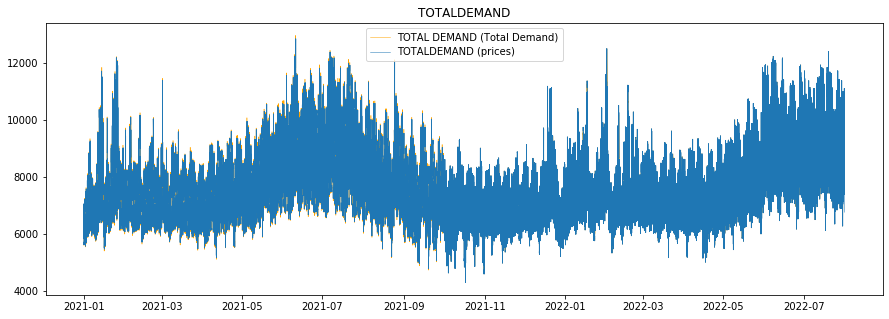

In [31]:
# Total Demand
x = df_lim.DATETIME
y1 = df_lim.TOTALDEMAND_x
y2 = df_lim.TOTALDEMAND_y

fig, ax = plt.subplots(figsize=(15,5))

ax.plot(x, y1, linewidth=0.5, label='TOTAL DEMAND (Total Demand)', color="orange")
ax.plot(x, y2, linewidth=0.5, label='TOTALDEMAND (prices)')

ax.set_title("TOTALDEMAND")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

plt.show() 

In [32]:
# set variables
x = df_lim.DATETIME
yTemp = df_lim.MAX
yDemand = df_lim.TOTALDEMAND_x
yRain = df_lim.RAIN
ySolar = df_lim.SOLAR

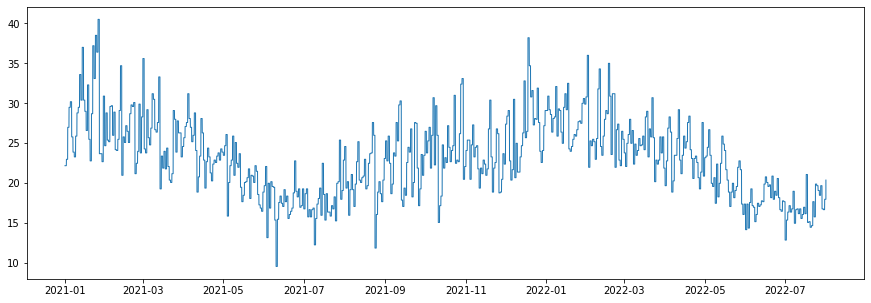

In [33]:
# Temperature
plt.figure(figsize=(15,5))
plt.plot(x, yTemp, linewidth=1)
plt.show() 

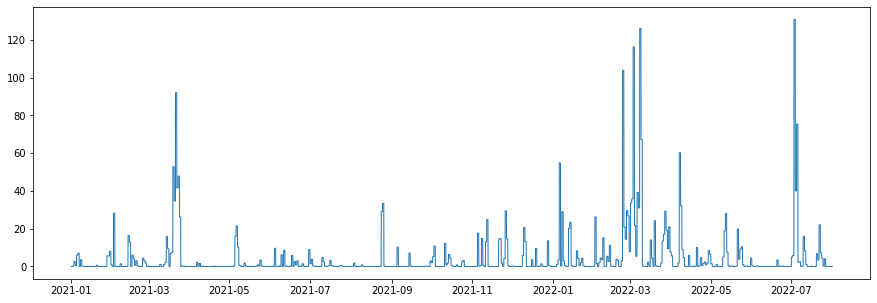

In [34]:
# Rain
plt.figure(figsize=(15,5))
plt.plot(x, yRain, linewidth=1)
plt.show() 

In [ ]:
# compare all variables
fig, ax1 = plt.subplots(figsize=(15,5))
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax1.plot(x, yDemand, linewidth=0.1, label='TOTALDEMAND', color="purple")
ax2.plot(x, yTemp, linewidth=1, label='TEMP', color="orange")
ax3.bar(x, yRain, linewidth=1, label='RAIN')
plt.show() 

In [ ]:
# compare all variables, but apply kernal smoothing on demand and temp
yTempSeries = pd.Series(yTemp)
yTempSmooth = yTempSeries.rolling(window=5, win_type='gaussian', center=True).mean(std=0.5)
yDemandSeries = pd.Series(yDemand)
yDemandSmooth = yDemandSeries.rolling(window=5, win_type='gaussian', center=True).mean(std=0.5)

fig, ax1 = plt.subplots(figsize=(15,5))
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax1.plot(x, yDemandSmooth, linewidth=0.1, label='TOTALDEMAND', color="purple")
ax2.plot(x, yTempSmooth, linewidth=1, label='TEMP', color="orange")
ax3.bar(x, yRain, linewidth=1, label='RAIN')
plt.show() 